In [ ]:
#!pip uninstall yfinance
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.0 MB/s eta 0:00:00


In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors

In [2]:
def preprocess_data(ticker, start_date, end_date, n_past=13, n_lookahead=13):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    close_prices = stock_data['Close'].values

    X, y = [], []
    for i in range(len(close_prices) - n_past - n_lookahead + 1):
        X.append(close_prices[i:i + n_past])
        y.append(close_prices[i + n_past + n_lookahead - 1])

    return np.array(X), np.array(y)

In [3]:
def compute_memberships(X, a, b):
    # Expand `a` and `b` to match the number of samples in `X`
    a = a.unsqueeze(1)
    b = b.unsqueeze(1)

    # Compute the distance
    distance = torch.sum(a * X.unsqueeze(2), dim=-1) + b

    # Compute softmax for memberships
    memberships = F.softmax(-distance, dim=-1)

    return memberships

In [4]:
class LearnableMembership(nn.Module):
    def __init__(self, input_dim, n_clusters):
        super(LearnableMembership, self).__init__()
        self.centers = nn.Parameter(torch.randn(n_clusters, input_dim))
        self.sigmas = nn.Parameter(torch.ones(n_clusters))

    def forward(self, x):
        diff = x.unsqueeze(2) - self.centers
        memberships = torch.exp(-torch.sum(diff**2, dim=-1) / (2 * self.sigmas**2))
        return memberships

In [5]:
def plot_k_distance(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    k_distances = np.sort(distances[:, k-1])  # Distance to k-th nearest neighbor
    plt.figure(figsize=(8, 4))
    plt.plot(k_distances)
    plt.title(f'{k}-Distance Graph')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}th Nearest Neighbor Distance')
    plt.grid(True)
    plt.show()

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def fuzzy_clustering_dbscan(X, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X)

    cluster_centers = []
    cluster_variances = []  # Track cluster variance for compactness
    noise_points = np.sum(cluster_labels == -1)  # Count noise points

    unique_labels = np.unique(cluster_labels[cluster_labels >= 0])  # Ignore noise (-1)

    for label in unique_labels:
        cluster_points = X[cluster_labels == label]
        center = cluster_points.mean(axis=0)
        variance = np.var(cluster_points, axis=0).mean()  # Compute variance

        cluster_centers.append(center)
        cluster_variances.append(variance)

    cluster_centers = np.array(cluster_centers)

    # Compute cluster compactness (average within-cluster variance)
    cluster_compactness = np.mean(cluster_variances) if cluster_variances else None

    # Compute cluster separation (average pairwise distance between cluster centers)
    if len(cluster_centers) > 1:
        cluster_separation = np.mean([np.linalg.norm(c1 - c2)
                                      for i, c1 in enumerate(cluster_centers)
                                      for c2 in cluster_centers[i+1:]])
    else:
        cluster_separation = None

    noise_ratio = noise_points / len(X)

    return cluster_labels, cluster_centers, cluster_compactness, cluster_separation, noise_ratio


def gaussian_membership(x, center, sigma=1.0):
    return np.exp(-np.square(x - center) / (2 * sigma**2))


def defuzzify(cluster_labels, cluster_centers, n_samples):
    reconstructed = np.full(n_samples, np.nan)

    for i, label in enumerate(cluster_labels):
        if label >= 0:  # If not noise point
            reconstructed[i] = cluster_centers[label]

    return reconstructed


def evaluate_clustering(X, reconstructed):
    mask = ~np.isnan(reconstructed)
    if np.sum(mask) == 0:
        return None, None  # If all points are noise, return None

    X_valid = X[mask]
    reconstructed_valid = reconstructed[mask]

    rmse = np.sqrt(mean_squared_error(X_valid, reconstructed_valid))
    r2 = r2_score(X_valid, reconstructed_valid)

    return rmse, r2

In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_clusters):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.n_clusters = n_clusters
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=3)
        self.fc_a = nn.Linear(hidden_dim, n_clusters * input_dim)
        self.fc_b = nn.Linear(hidden_dim, n_clusters)
        self.fc_c = nn.Linear(hidden_dim, n_clusters)
        self.membership = LearnableMembership(input_dim, n_clusters)

    def forward(self, x):

        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]

        a = torch.sigmoid(self.fc_a(last_out)).view(-1, self.n_clusters, self.input_dim)  # Keep between 0 and 1
        b = torch.sigmoid(self.fc_b(last_out)).view(-1, self.n_clusters)
        c = torch.sigmoid(self.fc_c(last_out)).view(-1, self.n_clusters)

        memberships = self.membership(x)

        return a, b, c, memberships

def tsk_layer(X, memberships, a, b, c):
    if X.dim() == 2:
        X = X.unsqueeze(-1)

    batch_size, num_samples, input_dim = X.shape
    n_clusters = memberships.shape[-1]

    X = X.unsqueeze(2)
    a = a.unsqueeze(1)
    b = b.unsqueeze(1)
    c = c.unsqueeze(1)

    rule_outputs = torch.sum(a * X, dim=-1) + b + c

    weighted_outputs = memberships * rule_outputs

    membership_sums = torch.sum(memberships, dim=-1, keepdim=True) + 1e-6
    normalized_weights = memberships / membership_sums
    final_output = torch.sum(normalized_weights * rule_outputs, dim=-1).unsqueeze(-1)

    return final_output

In [9]:
def compute_macd(prices, short_window=12, long_window=26, signal_window=9):
    # Ensure prices are 1-dimensional
    prices = np.squeeze(prices)

    # Calculate the MACD line and the Signal line
    short_ema = pd.Series(prices).ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = pd.Series(prices).ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

# Function to calculate returns based on MACD crossover
def calculate_returns(macd, signal_line, price_data):
    price_data = np.squeeze(price_data)

    signals = np.zeros(len(macd))
    returns = np.zeros(len(macd))

    # Generate trading signals (1 for buy, -1 for sell)
    for i in range(1, len(macd)):
        if macd[i] > signal_line[i] and macd[i - 1] <= signal_line[i - 1]:
            signals[i] = 1  # Buy signal
        elif macd[i] < signal_line[i] and macd[i - 1] >= signal_line[i - 1]:
            signals[i] = -1  # Sell signal

    # Calculate returns based on signals
    for i in range(1, len(macd)):
        if signals[i] != 0:
            # We calculate returns as the percentage change in price
            returns[i] = (price_data[i] - price_data[i - 1]) / price_data[i - 1] * signals[i]

    # Total return and number of trades
    total_return = np.sum(returns)
    num_trades = np.sum(np.abs(signals))  # Count the number of trades (buy or sell signals)

    return returns, total_return, num_trades

# Function to compute fMACD
def compute_fmacd(forecasted_prices, fast_period=12, slow_period=26, signal_period=9):
    forecasted_prices = np.squeeze(forecasted_prices)

    # Calculate forecasted MACD using forecasted prices
    macd, signal_line = compute_macd(forecasted_prices, fast_period, slow_period, signal_period)
    return macd, signal_line

In [13]:
def train_model(X_train, y_train, X_test, y_test, eps=0.5, min_samples=5, epochs=100, lr=0.001):
    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Standardize the flattened data for DBSCAN
    scaler = StandardScaler()
    n_samples, time_steps, n_features = X_train.shape
    X_train_flat = X_train.view(n_samples, -1).numpy()
    X_train_flat = scaler.fit_transform(X_train_flat)

    # Clustering using DBSCAN
    cluster_labels, cluster_centers, cluster_compactness, cluster_separation, noise_ratio = fuzzy_clustering_dbscan(X_train_flat, eps, min_samples)
    plot_k_distance(X_train_flat, 4)
    print(f"Cluster Compactness: {cluster_compactness}")
    print(f"Cluster Separation: {cluster_separation}")
    print(f"Noise Ratio: {noise_ratio}")

    if len(cluster_centers) == 0:
        print("DBSCAN found no clusters. Try adjusting eps or min_samples.")
        return None

    n_clusters = len(cluster_centers)
    print(f"DBSCAN found {n_clusters} clusters.")

    X_train = X_train.view(n_samples, time_steps, n_features)

    # Build RNN model
    model = RNNModel(input_dim=n_features, hidden_dim=64, n_clusters=n_clusters)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-5)
    loss_fn = nn.MSELoss()

    # Calculate fuzzy memberships
    memberships = np.array([gaussian_membership(X_train_flat, center) for center in cluster_centers]).T

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last = True)

    for epoch in range(epochs):

      model.train()
      epoch_loss = 0

      for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        a, b, c, memberships = model(X_batch)

        # Compute memberships
        memberships = compute_memberships(X_batch, a, b)

        if memberships.shape[0] != X_batch.shape[0]:
            memberships = memberships[:X_batch.shape[0], ...]

        # Compute final predictions
        predictions = tsk_layer(X_batch, memberships, a, b, c)

        if predictions.ndim == 3:
            predictions = predictions[:, -1, :]  # Keep the last time step

        # Compute loss
        loss = loss_fn(predictions, y_batch)
        epoch_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

    eval_dataset = TensorDataset(X_test, y_test)
    eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False, drop_last = True)

    # Testing
    model.eval()
    all_predictions = []

    with torch.no_grad():
      for X_eval, _ in eval_loader:
        a, b, c, memberships = model(X_eval)
        memberships = compute_memberships(X_eval, a, b)
        predictions = tsk_layer(X_eval, memberships, a, b, c)[:, -1, :]
        all_predictions.append(predictions.cpu().numpy())

    all_predictions = np.concatenate(all_predictions).flatten()

    # Evaluate metrics
    scaler = MinMaxScaler()
    scaled_y_test = scaler.fit_transform(y_test.numpy().reshape(-1, 1)).flatten()
    scaled_all_predictions = scaler.transform(all_predictions.reshape(-1, 1)).flatten()

    # Reshape scaled_y_test to match predictions
    scaled_y_test = scaled_y_test[:len(all_predictions)]

    # Compute RMSE and R2
    rmse = np.sqrt(np.mean((scaled_all_predictions - scaled_y_test) ** 2))
    r2 = r2_score(scaled_y_test, scaled_all_predictions)

    plt.figure(figsize=(10, 5))
    plt.plot(all_predictions, label='Predictions')
    plt.plot(y_test, label='Actual Values')
    plt.legend()
    plt.show()

    macd, signal_line = compute_macd(y_test)  # Use true values for vMACD

    fmacd, fsignal_line = compute_fmacd(all_predictions)  # Use forecasted values for fMACD

    # Calculate returns and number of trades for both vMACD and fMACD
    vmacd_returns, vmacd_total_return, vmacd_trades = calculate_returns(macd, signal_line, y_test)
    fmacd_returns, fmacd_total_return, fmacd_trades = calculate_returns(fmacd, fsignal_line, all_predictions)

    plt.figure(figsize=(10, 5))
    plt.plot(vmacd_returns, label='vMACD Returns')
    plt.plot(fmacd_returns, label='fMACD Returns')
    plt.legend()
    plt.show()

    print(f"vMACD Total Return: {vmacd_total_return:.4f}")
    print(f"fMACD Total Return: {fmacd_total_return:.4f}")
    print(f"Number of vMACD Trades: {vmacd_trades}")
    print(f"Number of fMACD Trades: {fmacd_trades}")

    return model, rmse, r2, n_clusters

[*********************100%***********************]  1 of 1 completed


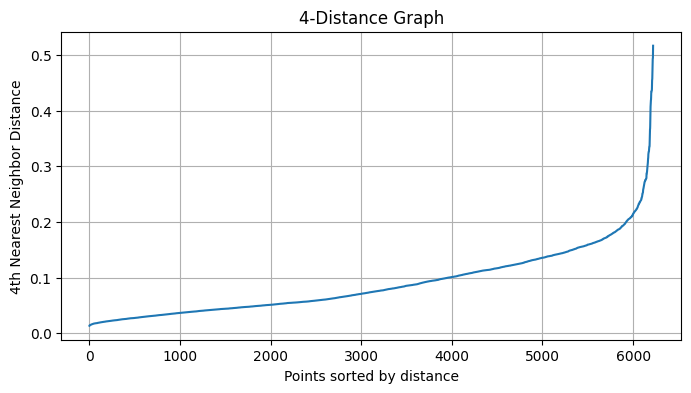

Cluster Compactness: 0.10581730306148529
Cluster Separation: 5.169978141784668
Noise Ratio: 0.03439408550305368
DBSCAN found 7 clusters.


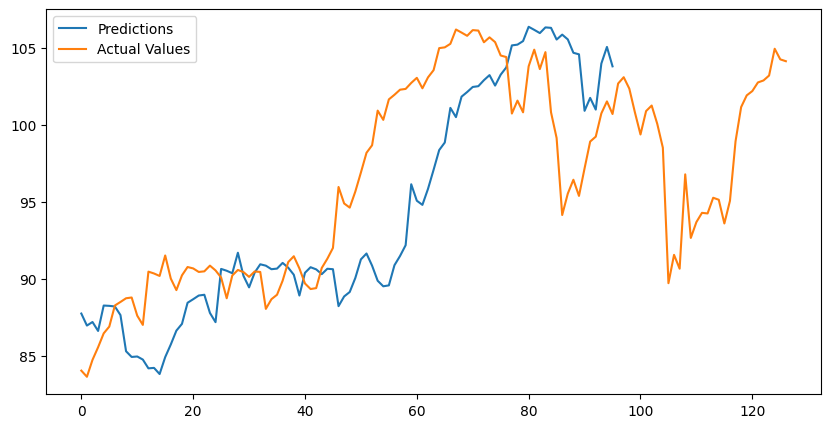

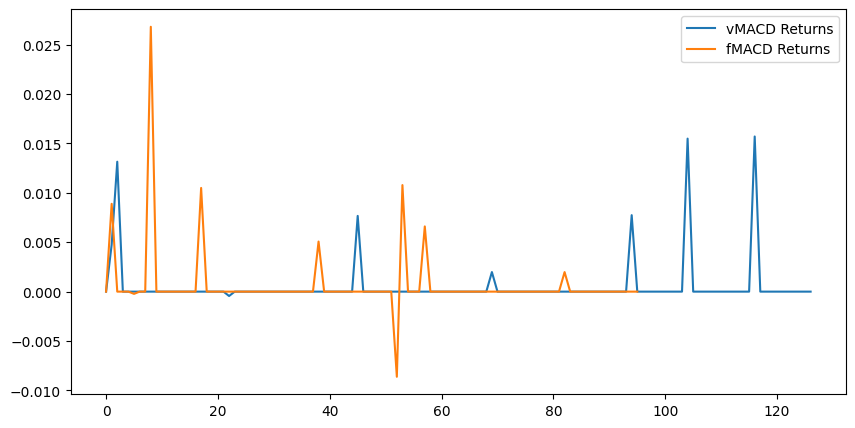

vMACD Total Return: 0.0661
fMACD Total Return: 0.0618
Number of vMACD Trades: 8.0
Number of fMACD Trades: 9.0


In [14]:
if __name__ == "__main__":
    # Load and preprocess data
    X, y = preprocess_data(ticker="BSX", start_date="2000-01-01", end_date="2025-05-07", n_past=13, n_lookahead=13) # Refer to main code for explanation

    y = y.flatten()

    # Split into train and test sets
    split_idx = int(0.98 * len(X))

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Train the model
    trained_model, rmse, r2, n_clusters = train_model(
        X_train, y_train, X_test, y_test, eps=0.2, min_samples=4, epochs=50, lr=0.001
    )